In [5]:
import numpy as np
import torch
import torch.nn as nn

In [113]:
# Define the neural network model for g(t, W)
class GModel(nn.Module):
    def __init__(self):
        super(GModel, self).__init__()
        self.fc1 = nn.Linear(1, 256)  # Input layer (1D input for t)
        self.fc2 = nn.Linear(256, 256)  # Hidden layer
        self.fc3 = nn.Linear(256, 256)  # Output layer (output is of shape params_shape)
        self.fc4 = nn.Linear(256, 1)  # Output layer (output is of shape params_shape)
        self.ac1 = nn.PReLU()
        self.ac2 = nn.Tanh()
        self.ac3 = nn.PReLU()

    def forward(self, t):
        t = t.view(-1, 1)  # Ensure input is of shape (batch_size, 1)
        x = self.ac1(self.fc1(t))
        x = self.ac2(self.fc2(x))
        x = self.ac3(self.fc3(x))
        return self.fc4(x)

In [182]:
# dX/dt = f(X,t)
# X = g(t,W); where W is parameters
# so we try to zero following equation
# dg/dt-f(g(t,W),t)
# and to add to it initial-value constraint: X(0)=x0
# we also try to minimize
# g(0,W)-x0
# by optimizing l(t,W) over W we will get


def f(X,t):
    return torch.cos(3*t)*X+torch.sin(2*X)*t

def difference(t,model,x0,t0):
    """returns difference between predicted and true derivative"""
    t.requires_grad=True
    g_value = model(t)
    g0 = model(t0)
    f_value = f(g_value,t)
    g_value.requires_grad_(True)  # Enable gradient tracking
    dgdt = torch.autograd.grad(g_value.sum(), t, create_graph=True,allow_unused=True)[0]

    return dgdt-f_value, g0-x0

def loss(t,model,x0,t0):
    deriv_diff,x0_diff = difference(t,model,x0,t0)
    return torch.mean(deriv_diff**2) + torch.mean(x0_diff**2)

In [145]:
from torch.nn.parallel import DataParallel as DP
tv = torch.tensor([1,2,3.0]).reshape((3,1)).cuda()
x0 = torch.tensor([1.0]).cuda()
t0 = torch.tensor([1.0]).cuda()
m = GModel()
m = DP(m)
loss(tv,m,x0,t0)

tensor(1.0462, device='cuda:0', grad_fn=<AddBackward0>)

In [210]:
# create dataset 
import torch
from torch.nn.parallel import DataParallel as DP
from torch.utils.data import DataLoader, TensorDataset

t_count = 2048
t_span = [-1,1]
batch_size = 256
t_values = torch.linspace(t_span[0],t_span[1],t_count).reshape((t_count,1))
# Initial condition
x0 = torch.tensor([1.0]).cuda()
t0 = torch.tensor([-1.0]).cuda()

# Convert the tensor to a TensorDataset
tensor_dataset = TensorDataset(t_values)

# Create the DataLoader with a batch size of 32
dataloader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

In [214]:
import torch.optim as optim
from tqdm import tqdm

model = DP(GModel()).cuda()
optimizer = optim.AdamW(model.parameters(),lr=1e-3)

# Number of epochs
num_epochs = 32
stop_at_loss = 1e-8

progress_bar = tqdm(range(num_epochs))
for epoch in progress_bar:
    # Wrap the dataloader with tqdm to add a progress bar
    running_loss = 0.0
    for b in dataloader:
        t_v = b[0].cuda()
        loss_ = loss(t_v, model,x0,t0)
        optimizer.zero_grad()
        loss_.backward()
        optimizer.step()
        # loss_ = torch.sum((model(t_v)-torch.sin(t_v))**2)
        running_loss += loss_.item()
    # Optionally, print or log the average loss per epoch
    avg_loss = running_loss / len(dataloader)
    progress_bar.set_postfix(loss=avg_loss)
    if avg_loss<stop_at_loss or np.isnan(avg_loss): break

100%|██████████| 32/32 [00:01<00:00, 19.96it/s, loss=0.00131]


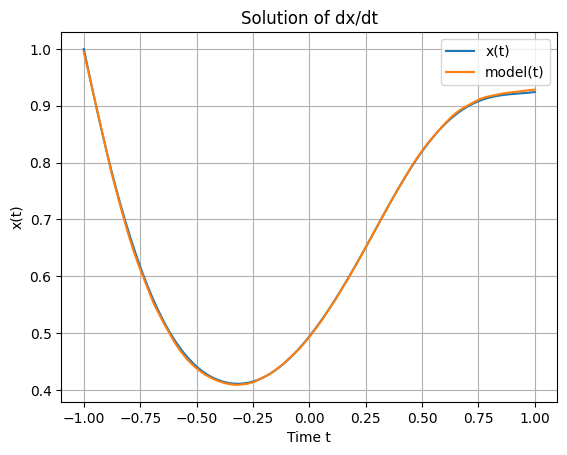

In [215]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the ODE function
def ode_function(t, x):
    return f(torch.tensor(x),torch.tensor(t))

t_eval = np.linspace(t_span[0], t_span[1], 100)
# Solve the ODE
solution = solve_ivp(ode_function, t_span,  x0.cpu(), t_eval=t_eval)

# Plotting the result
plt.plot(solution.t, solution.y[0], label='x(t)')

with torch.no_grad():
    plt.plot(t_values.cpu(),model(t_values).cpu(),label="model(t)")
    # plt.plot(t_values.cpu(),torch.cos(t_values).cpu())

plt.title("Solution of dx/dt")
plt.xlabel("Time t")
plt.ylabel("x(t)")
plt.legend()
plt.grid()
plt.show()